# Quantum Key Distribution Simulator: BB84 Protocol with Weak Coherent Sources

This notebook provides an educational simulation of the BB84 quantum key distribution protocol using weak coherent photon sources. The simulator models realistic system parameters including detector efficiency, channel loss, dark counts, and various error sources.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom
import math
from ThOPqkdsim.simBB84 import *

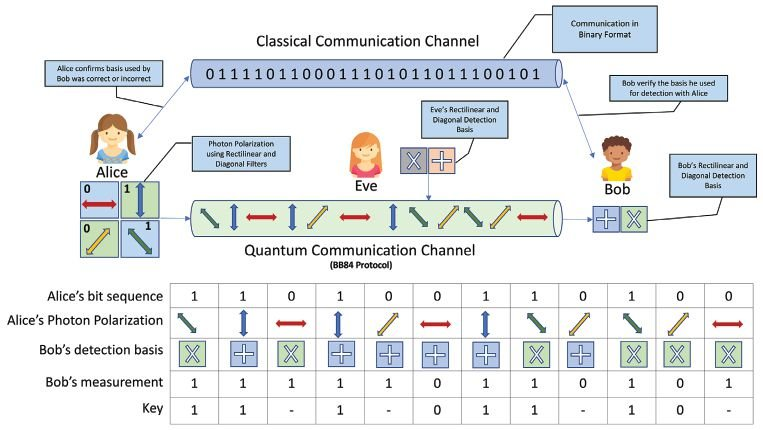

# 1. Introduction to Quantum Key Distribution

Quantum Key Distribution (QKD) is a secure communication method that uses principles of quantum mechanics to establish a shared secret key between two parties (traditionally called Alice and Bob). Unlike classical encryption methods that rely on computational complexity, QKD offers security based on fundamental laws of physics.

The BB84 Protocol
The BB84 protocol, proposed by Bennett and Brassard in 1984, was the first QKD protocol. It works as follows:

1) Quantum Transmission: Alice sends quantum states (qubits) to Bob
2) Measurement: Bob measures the received qubits
3) Basis Reconciliation: Alice and Bob publicly compare their basis choices
4) Key Sifting: They keep only the bits where they used the same basis
5) Error Estimation: They sacrifice some bits to estimate the error rate
6) Error Correction: They correct errors in the remaining bits
7) Privacy Amplification: They reduce the information an eavesdropper might have gained

<div style="text-align: center;">
    <img src="Figures/BB84/QKD_sim-BB84_steps.png" width="500">
</div>

# 2. Simulation Components

## 2.1 Weak Coherent Source
In practical QKD systems, we often use attenuated laser pulses instead of perfect single-photon sources. These weak coherent sources produce photon numbers that follow a Poisson distribution characterized by the mean photon number μ.

$P(n) = \frac{\mu^n e^{-\mu}}{n!}$

In [2]:
class WeakCoherentSource:
    """
    Simulates a weak coherent photon source for BB84 protocol.
    """
    def __init__(self, mu):
        """
        Initialize the photon source with mean photon number mu.
        
        Args:
            mu (float): Mean photon number per pulse
        """
        self.mu = mu
    
    def photon_distribution(self, n_max=20):
        """
        Calculate the Poisson photon number distribution for weak coherent states.
        
        Returns:
            np.array: Probability distribution of photon numbers
        """
        n_values = np.arange(n_max + 1)
        # Poisson distribution: P(n) = e^(-μ) * μ^n / n!
        p_n = np.exp(-self.mu) * (self.mu**n_values) / np.array([math.factorial(n) for n in n_values])
        return p_n

# 2.2 Quantum Channel
The quantum channel models the optical path between Alice and Bob. In fiber-based QKD, this includes losses due to fiber attenuation, coupling losses, and distance-dependent effects.

Key Concepts:

- Fiber attenuation typically ranges from 0.2 dB/km to 0.4 dB/km at telecom wavelengths
- Channel efficiency decreases exponentially with distance:    
$\eta = \eta _0 * 10^{-{\alpha  L}/10}$
- Misalignment errors increase with distance due to beam divergence and mechanical instabilities
- Photon transmission follows binomial statistics based on channel efficiency

In [3]:
class Channel:
    """
    Represents the quantum channel between Alice and Bob.
    """
    def __init__(self, base_efficiency, distance=0, attenuation=0.2):
        """
        Initialize the channel with distance-dependent efficiency.
        
        Args:
            base_efficiency (float): Base channel transmission efficiency without distance (0-1)
            distance (float): Channel distance in kilometers
            attenuation (float): Fiber attenuation coefficient in dB/km
        """
        self.base_efficiency = base_efficiency
        self.distance = distance
        self.attenuation = attenuation
        self.efficiency = self.calculate_efficiency()
        
        # Optical misalignment that increases with distance
        self.misalignment_base = 0.015  # 1.5% base misalignment error
        self.misalignment_factor = 0.0002  # Increase per km
    
    def calculate_efficiency(self):
        """
        Calculate the actual channel efficiency based on distance.
        
        Returns:
            float: Actual channel efficiency after distance attenuation
        """
        # Calculate attenuation in dB
        attenuation_db = self.distance * self.attenuation
        
        # Convert to transmission efficiency: 10^(-attenuation_db/10)
        distance_factor = 10**(-attenuation_db/10)
        
        # Total efficiency is base efficiency times distance factor
        return self.base_efficiency * distance_factor
    
    def update_distance(self, distance):
        """
        Update the channel distance and recalculate efficiency.
        
        Args:
            distance (float): New channel distance in kilometers
        """
        self.distance = distance
        self.efficiency = self.calculate_efficiency()
    
    def transmission_probability(self, sent_photons, received_photons):
        """
        Calculate probability of receiving photons given sent photons.
        
        Args:
            sent_photons (int): Number of photons sent
            received_photons (int): Number of photons received
            
        Returns:
            float: Probability of receiving the specified number of photons
        """
        if received_photons > sent_photons:
            return 0.0
        
        return binom.pmf(received_photons, sent_photons, self.efficiency)
    
    def calculate_misalignment_error(self):
        """
        Calculate optical misalignment error based on distance.
        
        Returns:
            float: Misalignment error probability (0-1)
        """
        # Error increases with distance but saturates
        return min(0.1, self.misalignment_base + self.misalignment_factor * self.distance)

## 2.3 Single-Photon Detector
Single-photon detectors are crucial components in QKD systems. This class models detector characteristics including efficiency, dark counts, afterpulsing, and timing jitter.

Key Concepts:

- Detector efficiency: Probability that an incident photon generates a detection event
- Dark counts: False detections due to thermal or electronic noise
- Dark count probability in a time window: 
$P_{dark} = 1 - e^{-DCR * \Delta t}$
- Afterpulsing: False detections that occur after a legitimate detection
- Timing jitter: Uncertainty in the detection time, which can lead to errors
- Detection probability for n photons: 
$P_{detect} = 1 - (1 - η)^n$

In [4]:
class Detector:
    """
    Represents a single-photon detector with noise characteristics.
    """
    def __init__(self, efficiency, dark_count_rate, time_window):
        """
        Initialize detector with its characteristics.
        
        Args:
            efficiency (float): Detector efficiency (0-1)
            dark_count_rate (float): Dark count rate in counts per second
            time_window (float): Detection time window in seconds
        """
        self.efficiency = efficiency
        self.dark_count_rate = dark_count_rate
        self.time_window = time_window
        self.p_dark = 1 - np.exp(-dark_count_rate * time_window)
        
        # Detector afterpulsing probability
        self.afterpulsing_prob = 0.02
        
        # Detector timing jitter (as error probability)
        self.timing_jitter_error = 0.01
    
    def detect_probability(self, photons):
        """
        Calculate the probability of detection given number of photons.
        
        Args:
            photons (int): Number of photons arriving at detector
            
        Returns:
            float: Probability of detection
        """
        # Probability of at least one photon being detected
        if photons > 0:
            # 1 - probability that none are detected
            p_detect_signal = 1 - (1 - self.efficiency)**photons
            
            # Add saturation effect for multiple photons (models crosstalk and other non-linearities)
            saturation_factor = 1.0
            if photons > 1:
                # Detector saturation for multi-photon pulses
                saturation_factor = 1.0 + 0.02 * (photons - 1)
                
            return min(1.0, p_detect_signal * saturation_factor)
        return 0
    
    def dark_count_probability(self):
        """
        Calculate the probability of a dark count in the detection window.
        
        Returns:
            float: Dark count probability
        """
        return self.p_dark

## 2.4 BB84 Protocol Simulator
The core simulator class integrates the components above to model the complete BB84 protocol, including error sources, sifting, error correction, and privacy amplification.

Key Parameters Explained:

- mu (float): Mean photon number per pulse (typical values: 0.1-0.5)
Controls the trade-off between key rate and security
Lower values reduce multi-photon vulnerabilities but also reduce raw key rate

- detector_efficiency (float): Probability that an incident photon generates a detection (typical: 0.1-0.25 for InGaAs APDs) Higher efficiency increases detection rates but can increase noise

- channel_base_efficiency (float): Base optical transmission efficiency without distance effects (typical: 0.5-0.8) Accounts for coupling losses, optical components, etc.

- dark_count_rate (float): False detections per second (typical: 100-5000 Hz) Higher dark count rates increase error rates, especially at long distances

- time_window (float): Detection window in seconds (typical: 1-10 ns) Longer windows increase dark count probability

- distance (float): Fiber length between Alice and Bob in kilometers Exponentially decreases channel efficiency

- attenuation (float): Fiber loss coefficient in dB/km (typical: 0.2-0.4 dB/km at telecom wavelengths) Higher values decrease transmission distance

- p_eve (float): Probability of eavesdropping (0-1) Models the fraction of pulses intercepted by Eve in intercept-resend attack

- n_max (int): Maximum photon number to consider in calculations Truncates Poisson distribution for computational efficiency
Should be large enough that neglected terms are negligible

- confidence (float): Statistical confidence level for error estimation (typical: 0.95) Higher values are more conservative in security estimates

- repetition_rate (float): Source pulse rate in Hz (typical: 1-10 MHz) Higher rates increase raw key generation rate

- optical_error_base (float): Base optical error rate due to imperfections Accounts for phase errors, polarization errors, etc.

- multi_photon_error_factor (float): Additional error contribution per photon for multi-photon pulses Models increased error probability for multi-photon events

In [5]:
class BB84:
    """
    Simulates the BB84 QKD protocol with weak coherent source.
    """
    def __init__(self, mu, detector_efficiency, channel_base_efficiency,
                 dark_count_rate, time_window, distance=0, attenuation=0.2, p_eve=0.0):
        """
        Initialize the BB84 simulator.
        
        Args:
            mu (float): Mean photon number
            detector_efficiency (float): Bob's detector efficiency
            channel_base_efficiency (float): Base efficiency of quantum channel
            dark_count_rate (float): Dark count rate in counts per second
            time_window (float): Detection time window in seconds
            distance (float): Distance between Alice and Bob in kilometers
            attenuation (float): Fiber attenuation coefficient in dB/km
            p_eve (float): Probability of Eve performing intercept-resend attack
        """
        self.source = WeakCoherentSource(mu)
        self.mu = mu
        self.channel = Channel(channel_base_efficiency, distance, attenuation)
        self.detector = Detector(detector_efficiency, dark_count_rate, time_window)
        self.distance = distance
        self.attenuation = attenuation
        self.p_eve = p_eve
        self.n_max = 10  # Maximum photon number to consider in calculations
        self.confidence = 0.95  # Statistical confidence for error estimation
        self.time_window = time_window
        self.repetition_rate = 1e6  # Default pulse rate: 1 MHz
        
        # Additional error sources
        self.optical_error_base = 0.01  # Base optical error rate (1%)
        self.multi_photon_error_factor = 0.02  # Additional error per photon for multi-photon pulses

# 3. Implementation Details
Let's implement the rest of the BB84Simulator class methods, which calculate various QKD performance metrics:

## 3.1 Distance and Mean Photon Number Methods
These methods allow updating the simulation parameters:

In [6]:
def update_distance(self, distance):
    """
    Update the distance between Alice and Bob and recalculate channel efficiency.
    
    Args:
        distance (float): New distance in kilometers
    """
    self.distance = distance
    self.channel.update_distance(distance)

def update_mu(self, mu):
    """
    Update the mean photon number.
    
    Args:
        mu (float): New mean photon number
    """
    self.mu = mu
    self.source = WeakCoherentSource(mu)

## 3.2 Key Rate Calculation Methods
These methods calculate the raw and sifted key rates:

calculate_raw_key_rate():

- Calculates the probability of a detection event per pulse
- Considers three scenarios:
1.  Signal photons are detected 
2.  Dark counts occur when no photons are sent
3. Dark counts occur when signal photons aren't detected
- Accounts for photon number distribution, channel transmission, and detector characteristics
- Returns the raw detection probability per pulse (before basis reconciliation)


calculate_sifted_key_rate():

- Calculates the key rate after basis reconciliation
- In BB84, Alice and Bob use matching bases ~50% of the time by chance
- Therefore, sifted key rate is approximately half of the raw key rate
- Returns the sifted key rate in bits per pulse

In [7]:
def calculate_raw_key_rate(self):
    """
    Calculate the raw key rate (before sifting).
    
    Returns:
        float: Raw key rate in bits per pulse
    """
    # Probability that at least one photon is received and detected
    p_distribution = self.source.photon_distribution(self.n_max)
    
    # Raw key rate before sifting - probability of detection per pulse
    raw_rate = 0
    for n in range(1, self.n_max + 1):  # Start from n=1 (at least one photon)
        # Probability that n photons are sent
        p_n = p_distribution[n]
        
        # Calculate probability of receiving and detecting at least one photon
        p_detect_n = 0
        for k in range(1, n + 1):  # k photons reach Bob
            # Probability that k out of n photons reach Bob
            p_trans = self.channel.transmission_probability(n, k)
            # Probability that at least one of k photons is detected
            p_detect = self.detector.detect_probability(k)
            p_detect_n += p_trans * p_detect
        
        raw_rate += p_n * p_detect_n
    
    # Add probability of dark count when no photon is detected
    p_no_photon = p_distribution[0]  # Probability of sending zero photons
    p_dark = self.detector.dark_count_probability()
    raw_rate += p_no_photon * p_dark
    
    # For non-zero photons that aren't detected, there's still a chance of dark count
    for n in range(1, self.n_max + 1):
        p_n = p_distribution[n]
        
        # Probability no photons are detected (includes all transmission possibilities)
        p_no_detect = 0
        for k in range(n + 1):  # 0 to n photons reach Bob
            p_trans = self.channel.transmission_probability(n, k)
            p_not_detect = (1 - self.detector.detect_probability(k))
            p_no_detect += p_trans * p_not_detect
        
        # Add probability of dark count when signal photons aren't detected
        raw_rate += p_n * p_no_detect * p_dark
    
    return raw_rate

def calculate_sifted_key_rate(self):
    """
    Calculate the sifted key rate (after basis reconciliation).
    
    Returns:
        float: Sifted key rate in bits per pulse
    """
    # After basis reconciliation, approximately half of the raw bits remain
    return self.calculate_raw_key_rate() * 0.5

## 3.3 Error Rate Calculation Methods
These methods calculate the quantum bit error rate (QBER) and statistical error:

calculate_quantum_bit_error_rate():

- Calculates the probability of bit errors in the sifted key
- Considers multiple error sources: 
1. Optical errors (misalignment, timing jitter, multi-photon errors) 
2. Dark count errors (random 50% error probability) 
3. Afterpulsing errors 
4. Eavesdropping-induced errors
- For eavesdropping, models intercept-resend attack: Eve correctly measures 50% of intercepted bits (correct basis choice)
Of these, she introduces errors in 25% (wrong bit value despite correct basis)
- Returns QBER as a percentage


statistical_error(measured_error_rate, n_samples):

- Calculates the statistical uncertainty in QBER estimation
- Based on binomial distribution confidence intervals
- Used for finite-key security analysis
- Takes into account: 
1. Measured error rate 
2. Number of sample bits used for estimation 
3. Desired confidence level (self.confidence)
- Returns the statistical error margin

In [8]:
def calculate_quantum_bit_error_rate(self):
    """
    Calculate the quantum bit error rate (QBER) for the BB84 protocol.
    
    Returns:
        float: QBER as a percentage
    """
    p_distribution = self.source.photon_distribution(self.n_max)
    
    # Channel efficiency decreases exponentially with distance
    channel_efficiency = self.channel.efficiency
    
    # Misalignment error inversely proportional to channel efficiency
    # (harder to maintain alignment as signal weakens)
    misalignment_error = self.channel.misalignment_base + self.channel.misalignment_factor * self.distance
    
    # Calculate error sources
    p_dark = self.detector.dark_count_probability()
    p_sig_correct = 0
    p_sig_error = 0
    
    # Calculate signal error probabilities
    for n in range(1, self.n_max + 1):
        p_n = p_distribution[n]
        multi_photon_error = self.optical_error_base
        if n > 1:
            multi_photon_error += self.multi_photon_error_factor * (n - 1)
        
        for k in range(1, n + 1):
            p_trans = self.channel.transmission_probability(n, k)
            p_detect = self.detector.detect_probability(k)
            
            # Total optical error without artificial caps
            p_optical_error = misalignment_error + self.detector.timing_jitter_error + multi_photon_error
            
            if self.p_eve == 0:
                p_sig_correct += p_n * p_trans * p_detect * (1 - p_optical_error)
                p_sig_error += p_n * p_trans * p_detect * p_optical_error
            else:
                eve_no_error = (1 - self.p_eve) * (1 - p_optical_error) + self.p_eve * 0.75 * (1 - p_optical_error)
                eve_error = (1 - self.p_eve) * p_optical_error + self.p_eve * 0.25 + self.p_eve * 0.75 * p_optical_error
                
                p_sig_correct += p_n * p_trans * p_detect * eve_no_error
                p_sig_error += p_n * p_trans * p_detect * eve_error
    
    # Dark count errors (50% chance of wrong bit)
    p_dark_error = 0.5 * p_dark * (1 - p_sig_correct - p_sig_error)
    
    # Afterpulsing errors
    p_afterpulse_error = 0.5 * (p_sig_correct + p_sig_error) * self.detector.afterpulsing_prob
    
    # Total error probability
    p_error = p_sig_error + p_dark_error + p_afterpulse_error
    
    # QBER calculation - no artificial scaling needed
    p_detect_total = self.calculate_sifted_key_rate() * 2
    
    # As channel efficiency decreases, dark count contribution naturally increases
    qber = (p_error / p_detect_total) * 100 if p_detect_total > 0 else 100

    return qber

def statistical_error(self, measured_error_rate, n_samples):
    """
    Calculate the statistical error in the QBER estimation.
    
    Args:
        measured_error_rate (float): Measured error rate (ζ)
        n_samples (int): Number of sample bits used for estimation
        
    Returns:
        float: Statistical error (ε)
    """
    if measured_error_rate == 0 or measured_error_rate == 1:
        return 0
    
    # ε = √[ζ(1-ζ)/(ζNSamples(1-S))]
    epsilon = np.sqrt(measured_error_rate * (1 - measured_error_rate) / 
                    (measured_error_rate * n_samples * (1 - self.confidence)))
    
    return epsilon

## 3.4 Information Theory and Security Methods
These methods implement the information theory calculations needed for security analysis:


error_correction_efficiency(error_rate)
- Calculates the fraction of bits lost during error correction
- Based on the theoretical limit from information theory (binary entropy function)
- Includes a 1.1× inefficiency factor to account for real error correction protocols
- Returns the fraction of bits lost (0-1)

privacy_amplification_efficiency(error_rate)
- Calculates the fraction of bits lost during privacy amplification
- Accounts for:
  - Base privacy amplification due to error rate
  - Additional privacy amplification for multi-photon pulses
- Returns the fraction of bits lost (0-1)

h_binary(p)
- Calculates the binary entropy function: H(p) = -p·log₂(p) - (1-p)·log₂(1-p)
- Fundamental in information theory for calculating mutual information
- Used for error correction and privacy amplification calculations
- Returns entropy value between 0 and 1

calculate_skr()
- Calculates the final secret key rate after all security processing
- Implements a simplified version of the GLLP (Gottesman-Lo-Lütkenhaus-Preskill) formula
- Accounts for:
  - Sifted key rate (raw detection rate after basis reconciliation)
  - QBER (quantum bit error rate)
  - Error correction overhead
  - Privacy amplification to account for eavesdropping and multi-photon pulses
- Calculates gain (detection probability) for:
  - Single-photon pulses (secure)
  - Multi-photon pulses (vulnerable to PNS attacks)
  - Dark counts (random bits)
- Returns the final secure key rate in bits per pulse (≥ 0)

In [9]:
def error_correction_efficiency(self, error_rate):
    """
    Calculate the fraction of bits lost due to error correction.
    
    Args:
        error_rate (float): Error rate (δ)
        
    Returns:
        float: Fraction of bits lost in error correction
    """
    if error_rate <= 0:
        return 0
    
    # r_ec = 1.1 × h_binary(error_rate)
    r_ec = 1.1 * self.h_binary(error_rate)
    
    return r_ec

def privacy_amplification_efficiency(self, error_rate):
    """
    Calculate the fraction of bits lost due to privacy amplification.
    
    Args:
        error_rate (float): Error rate (δ)
        
    Returns:
        float: Fraction of bits lost in privacy amplification
    """
    # Simplified privacy amplification factor based on multi-photon probability
    p_distribution = self.source.photon_distribution(self.n_max)
    p_multi = sum(p_distribution[2:])  # Probability of multi-photon pulses
    
    # Base privacy amplification fraction
    r_pa_base = 0.1 + error_rate
    
    # Additional privacy amplification needed for multi-photon pulses
    r_pa_multi = p_multi * 0.5
    
    return r_pa_base + r_pa_multi

def h_binary(self, p):
    """
    Binary entropy function H(p) = -p*log2(p) - (1-p)*log2(1-p).
    
    Args:
        p (float): Probability (0 <= p <= 1)
        
    Returns:
        float: Binary entropy value
    """
    if p == 0 or p == 1:
        return 0
    return -p * np.log2(p) - (1 - p) * np.log2(1 - p)

def calculate_skr(self):
    """
    Calculate the secret key rate (SKR) after error correction and privacy amplification.
    
    Returns:
        float: Secret key rate in bits per pulse
    """
    # Get photon number distribution
    p_distribution = self.source.photon_distribution(self.n_max)
    
    # Probability of single-photon pulses - crucial for secure key generation
    p_single = p_distribution[1]
    
    # Probability of multi-photon pulses - vulnerable to photon-number-splitting attacks
    p_multi = sum(p_distribution[2:])
    
    # Calculate the sifted key rate
    sifted_rate = self.calculate_sifted_key_rate()
    
    # Calculate QBER
    qber = self.calculate_quantum_bit_error_rate() / 100  # Convert from percentage to fraction
    
    # Calculate transmission gain for single-photon pulses
    gain_single = 0
    for k in range(1, 2):  # For single-photon pulses, only k=1 is possible
        p_trans = self.channel.transmission_probability(1, k)
        p_detect = self.detector.detect_probability(k)
        gain_single += p_single * p_trans * p_detect
    
    # Calculate gain for multi-photon pulses (vulnerable to PNS attacks)
    gain_multi = 0
    for n in range(2, self.n_max + 1):  # Multi-photon pulses
        p_n = p_distribution[n]
        gain_n = 0
        for k in range(1, n + 1):  # k photons reach Bob
            p_trans = self.channel.transmission_probability(n, k)
            p_detect = self.detector.detect_probability(k)
            gain_n += p_trans * p_detect
        gain_multi += p_n * gain_n
    
    # Calculate detection probability from dark counts
    p_dark = self.detector.dark_count_probability()
    p_no_photon = p_distribution[0]  # Probability of sending zero photons
    gain_dark = p_no_photon * p_dark
    
    # Total gain (detection probability)
    gain_total = gain_single + gain_multi + gain_dark
    
    # Fraction of detections from single-photon pulses (secure)
    f_single = gain_single / gain_total if gain_total > 0 else 0
    
    # Fraction of detections from multi-photon pulses (vulnerable)
    f_multi = gain_multi / gain_total if gain_total > 0 else 0
    
    # Fraction of detections from dark counts (adds to error)
    f_dark = gain_dark / gain_total if gain_total > 0 else 0
    
    # Error correction and privacy amplification overhead
    r_ec = self.error_correction_efficiency(qber)
    
    # Modified QBER to account for relative contributions
    # Dark counts and multi-photon pulses add to effective error rate
    effective_qber = qber + 0.5 * f_dark + 0.1 * f_multi
    
    # Information leakage due to multi-photon pulses
    info_leakage = f_multi
    
    # Calculate the final secret key rate using the GLLP formula
    # R = R_sifted * [1 - h_2(QBER) - leakage]
    skr = sifted_rate * (1 - self.h_binary(effective_qber) - r_ec - info_leakage)
    
    # No negative key rates
    return max(0, skr)

## 3.5 The Complete BB84Simulator Class
For convenience, here's the complete BB84Simulator class with all methods:

In [10]:
class BB84Simulator:
    """
    Simulates the BB84 QKD protocol with weak coherent source.
    """
    def __init__(self, mu, detector_efficiency, channel_base_efficiency,
                 dark_count_rate, time_window, distance=0, attenuation=0.2, p_eve=0.0):
        """
        Initialize the BB84 simulator.
        
        Args:
            mu (float): Mean photon number
            detector_efficiency (float): Bob's detector efficiency
            channel_base_efficiency (float): Base efficiency of quantum channel
            dark_count_rate (float): Dark count rate in counts per second
            time_window (float): Detection time window in seconds
            distance (float): Distance between Alice and Bob in kilometers
            attenuation (float): Fiber attenuation coefficient in dB/km
            p_eve (float): Probability of Eve performing intercept-resend attack
        """
        self.source = WeakCoherentSource(mu)
        self.mu = mu
        self.channel = Channel(channel_base_efficiency, distance, attenuation)
        self.detector = Detector(detector_efficiency, dark_count_rate, time_window)
        self.distance = distance
        self.attenuation = attenuation
        self.p_eve = p_eve
        self.n_max = 10  # Maximum photon number to consider in calculations
        self.confidence = 0.95  # Statistical confidence for error estimation
        self.time_window = time_window
        self.repetition_rate = 1e6  # Default pulse rate: 1 MHz
        
        # Additional error sources
        self.optical_error_base = 0.01  # Base optical error rate (1%)
        self.multi_photon_error_factor = 0.02  # Additional error per photon for multi-photon pulses
    
    def update_distance(self, distance):
        """
        Update the distance between Alice and Bob and recalculate channel efficiency.
        
        Args:
            distance (float): New distance in kilometers
        """
        self.distance = distance
        self.channel.update_distance(distance)
    
    def update_mu(self, mu):
        """
        Update the mean photon number.
        
        Args:
            mu (float): New mean photon number
        """
        self.mu = mu
        self.source = WeakCoherentSource(mu)
    
    def calculate_raw_key_rate(self):
        """
        Calculate the raw key rate (before sifting).
        
        Returns:
            float: Raw key rate in bits per pulse
        """
        # Probability that at least one photon is received and detected
        p_distribution = self.source.photon_distribution(self.n_max)
        
        # Raw key rate before sifting - probability of detection per pulse
        raw_rate = 0
        for n in range(1, self.n_max + 1):  # Start from n=1 (at least one photon)
            # Probability that n photons are sent
            p_n = p_distribution[n]
            
            # Calculate probability of receiving and detecting at least one photon
            p_detect_n = 0
            for k in range(1, n + 1):  # k photons reach Bob
                # Probability that k out of n photons reach Bob
                p_trans = self.channel.transmission_probability(n, k)
                # Probability that at least one of k photons is detected
                p_detect = self.detector.detect_probability(k)
                p_detect_n += p_trans * p_detect
            
            raw_rate += p_n * p_detect_n
        
        # Add probability of dark count when no photon is detected
        p_no_photon = p_distribution[0]  # Probability of sending zero photons
        p_dark = self.detector.dark_count_probability()
        raw_rate += p_no_photon * p_dark
        
        # For non-zero photons that aren't detected, there's still a chance of dark count
        for n in range(1, self.n_max + 1):
            p_n = p_distribution[n]
            
            # Probability no photons are detected (includes all transmission possibilities)
            p_no_detect = 0
            for k in range(n + 1):  # 0 to n photons reach Bob
                p_trans = self.channel.transmission_probability(n, k)
                p_not_detect = (1 - self.detector.detect_probability(k))
                p_no_detect += p_trans * p_not_detect
            
            # Add probability of dark count when signal photons aren't detected
            raw_rate += p_n * p_no_detect * p_dark
        
        return raw_rate
    
    def calculate_sifted_key_rate(self):
        """
        Calculate the sifted key rate (after basis reconciliation).
        
        Returns:
            float: Sifted key rate in bits per pulse
        """
        # After basis reconciliation, approximately half of the raw bits remain
        return self.calculate_raw_key_rate() * 0.5
    
    def calculate_quantum_bit_error_rate(self):
        """
        Calculate the quantum bit error rate (QBER) for the BB84 protocol.
        
        Returns:
            float: QBER as a percentage
        """
        p_distribution = self.source.photon_distribution(self.n_max)
        
        # Channel efficiency decreases exponentially with distance
        channel_efficiency = self.channel.efficiency
        
        # Misalignment error inversely proportional to channel efficiency
        # (harder to maintain alignment as signal weakens)
        misalignment_error = self.channel.misalignment_base + self.channel.misalignment_factor * self.distance
        
        # Calculate error sources
        p_dark = self.detector.dark_count_probability()
        p_sig_correct = 0
        p_sig_error = 0
        
        # Calculate signal error probabilities
        for n in range(1, self.n_max + 1):
            p_n = p_distribution[n]
            multi_photon_error = self.optical_error_base
            if n > 1:
                multi_photon_error += self.multi_photon_error_factor * (n - 1)
            
            for k in range(1, n + 1):
                p_trans = self.channel.transmission_probability(n, k)
                p_detect = self.detector.detect_probability(k)
                
                # Total optical error without artificial caps
                p_optical_error = misalignment_error + self.detector.timing_jitter_error + multi_photon_error
                
                if self.p_eve == 0:
                    p_sig_correct += p_n * p_trans * p_detect * (1 - p_optical_error)
                    p_sig_error += p_n * p_trans * p_detect * p_optical_error
                else:
                    eve_no_error = (1 - self.p_eve) * (1 - p_optical_error) + self.p_eve * 0.75 * (1 - p_optical_error)
                    eve_error = (1 - self.p_eve) * p_optical_error + self.p_eve * 0.25 + self.p_eve * 0.75 * p_optical_error
                    
                    p_sig_correct += p_n * p_trans * p_detect * eve_no_error
                    p_sig_error += p_n * p_trans * p_detect * eve_error
        
        # Dark count errors (50% chance of wrong bit)
        p_dark_error = 0.5 * p_dark * (1 - p_sig_correct - p_sig_error)
        
        # Afterpulsing errors
        p_afterpulse_error = 0.5 * (p_sig_correct + p_sig_error) * self.detector.afterpulsing_prob
        
        # Total error probability
        p_error = p_sig_error + p_dark_error + p_afterpulse_error
        
        # QBER calculation - no artificial scaling needed
        p_detect_total = self.calculate_sifted_key_rate() * 2
        
        # As channel efficiency decreases, dark count contribution naturally increases
        qber = (p_error / p_detect_total) * 100 if p_detect_total > 0 else 100

        return qber

    def statistical_error(self, measured_error_rate, n_samples):
        """
        Calculate the statistical error in the QBER estimation.
        
        Args:
            measured_error_rate (float): Measured error rate (ζ)
            n_samples (int): Number of sample bits used for estimation
            
        Returns:
            float: Statistical error (ε)
        """
        if measured_error_rate == 0 or measured_error_rate == 1:
            return 0
        
        # ε = √[ζ(1-ζ)/(ζNSamples(1-S))]
        epsilon = np.sqrt(measured_error_rate * (1 - measured_error_rate) / 
                         (measured_error_rate * n_samples * (1 - self.confidence)))
        
        return epsilon
    
    def error_correction_efficiency(self, error_rate):
        """
        Calculate the fraction of bits lost due to error correction.
        
        Args:
            error_rate (float): Error rate (δ)
            
        Returns:
            float: Fraction of bits lost in error correction
        """
        if error_rate <= 0:
            return 0
        
        # r_ec = 1.1 × h_binary(error_rate)
        r_ec = 1.1 * self.h_binary(error_rate)
        
        return r_ec
    
    def privacy_amplification_efficiency(self, error_rate):
        """
        Calculate the fraction of bits lost due to privacy amplification.
        
        Args:
            error_rate (float): Error rate (δ)
            
        Returns:
            float: Fraction of bits lost in privacy amplification
        """
        # Simplified privacy amplification factor based on multi-photon probability
        p_distribution = self.source.photon_distribution(self.n_max)
        p_multi = sum(p_distribution[2:])  # Probability of multi-photon pulses
        
        # Base privacy amplification fraction
        r_pa_base = 0.1 + error_rate
        
        # Additional privacy amplification needed for multi-photon pulses
        r_pa_multi = p_multi * 0.5
        
        return r_pa_base + r_pa_multi
    
    def h_binary(self, p):
        """
        Binary entropy function H(p) = -p*log2(p) - (1-p)*log2(1-p).
        
        Args:
            p (float): Probability (0 <= p <= 1)
            
        Returns:
            float: Binary entropy value
        """
        if p == 0 or p == 1:
            return 0
        return -p * np.log2(p) - (1 - p) * np.log2(1 - p)
    
    def calculate_skr(self):
        """
        Calculate the secret key rate (SKR) after error correction and privacy amplification.
        
        Returns:
            float: Secret key rate in bits per pulse
        """
        # Get photon number distribution
        p_distribution = self.source.photon_distribution(self.n_max)
        
        # Probability of single-photon pulses - crucial for secure key generation
        p_single = p_distribution[1]
        
        # Probability of multi-photon pulses - vulnerable to photon-number-splitting attacks
        p_multi = sum(p_distribution[2:])
        
        # Calculate the sifted key rate
        sifted_rate = self.calculate_sifted_key_rate()
        
        # Calculate QBER
        qber = self.calculate_quantum_bit_error_rate() / 100  # Convert from percentage to fraction
        
        # Calculate transmission gain for single-photon pulses
        gain_single = 0
        for k in range(1, 2):  # For single-photon pulses, only k=1 is possible
            p_trans = self.channel.transmission_probability(1, k)
            p_detect = self.detector.detect_probability(k)
            gain_single += p_single * p_trans * p_detect
        
        # Calculate gain for multi-photon pulses (vulnerable to PNS attacks)
        gain_multi = 0
        for n in range(2, self.n_max + 1):  # Multi-photon pulses
            p_n = p_distribution[n]
            gain_n = 0
            for k in range(1, n + 1):  # k photons reach Bob
                p_trans = self.channel.transmission_probability(n, k)
                p_detect = self.detector.detect_probability(k)
                gain_n += p_trans * p_detect
            gain_multi += p_n * gain_n
        
        # Calculate detection probability from dark counts
        p_dark = self.detector.dark_count_probability()
        p_no_photon = p_distribution[0]  # Probability of sending zero photons
        gain_dark = p_no_photon * p_dark
        
        # Total gain (detection probability)
        gain_total = gain_single + gain_multi + gain_dark
        
        # Fraction of detections from single-photon pulses (secure)
        f_single = gain_single / gain_total if gain_total > 0 else 0
        
        # Fraction of detections from multi-photon pulses (vulnerable)
        f_multi = gain_multi / gain_total if gain_total > 0 else 0
        
        # Fraction of detections from dark counts (adds to error)
        f_dark = gain_dark / gain_total if gain_total > 0 else 0
        
        # Error correction and privacy amplification overhead
        r_ec = self.error_correction_efficiency(qber)
        
        # Modified QBER to account for relative contributions
        # Dark counts and multi-photon pulses add to effective error rate
        effective_qber = qber + 0.5 * f_dark + 0.1 * f_multi
        
        # Information leakage due to multi-photon pulses
        info_leakage = f_multi
        
        # Calculate the final secret key rate using the GLLP formula
        # R = R_sifted * [1 - h_2(QBER) - leakage]
        skr = sifted_rate * (1 - self.h_binary(effective_qber) - r_ec - info_leakage)
        
        # No negative key rates
        return max(0, skr)

## 3.5.1 QBER Calculation 

<div style="text-align: center;">
    <img src="Figures/BB84/QKD_sim-BB84_QBER.png" width="700">
</div>

## 3.5.2 SKR Calculation

<div style="text-align: center;">
    <img src="Figures/BB84/QKD_sim-BB84 SKR.png" width="500">
</div>

# 4. Simulation Examples
Now let's run some simulations to explore the behavior of the BB84 protocol under different conditions.

## 4.1 QBER vs Mean Photon Number (μ)
First, let's examine how the mean photon number affects the quantum bit error rate (QBER). The QBER is a critical parameter that determines the security of the QKD system.

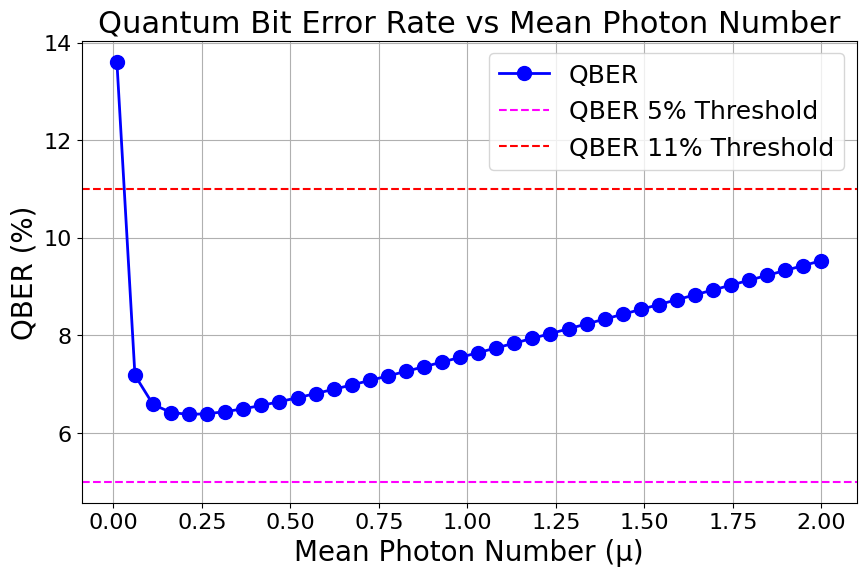

Optimal μ value: 0.214
Minimum QBER: 6.379%


In [11]:
# Define realistic system parameters
detector_eff = 0.15      # 15% detector efficiency
channel_eff = 0.60       # 60% base channel efficiency
dark_counts = 2000       # 2000 dark counts per second
time_window = 10e-9      # 10 ns detection window
distance = 50            # 50 km fiber distance

# Plot QBER vs mean photon number
mu_values, qber_values = plot_qber_vs_mu(
    time_window=time_window,
    distance=distance,
    detector_efficiency=detector_eff,
    channel_base_efficiency=channel_eff,
    dark_count_rate=dark_counts
)

# Show the optimal mu value (minimum QBER)
min_qber_idx = np.argmin(qber_values)
print(f"Optimal μ value: {mu_values[min_qber_idx]:.3f}")
print(f"Minimum QBER: {qber_values[min_qber_idx]:.3f}%")

Analysis:

- The horizontal lines at 5% and 11% represent typical warning and security thresholds
- As μ increases, multi-photon errors increase due to PNS attack vulnerability
- As μ decreases, dark count contribution increases relative to signal
- The optimal μ value balances these effects to minimize QBER

## 4.2 Secret Key Rate vs Mean Photon Number (μ)
Now let's examine how the mean photon number affects the secret key rate (SKR). The SKR is the final secure key generation rate after all post-processing steps.

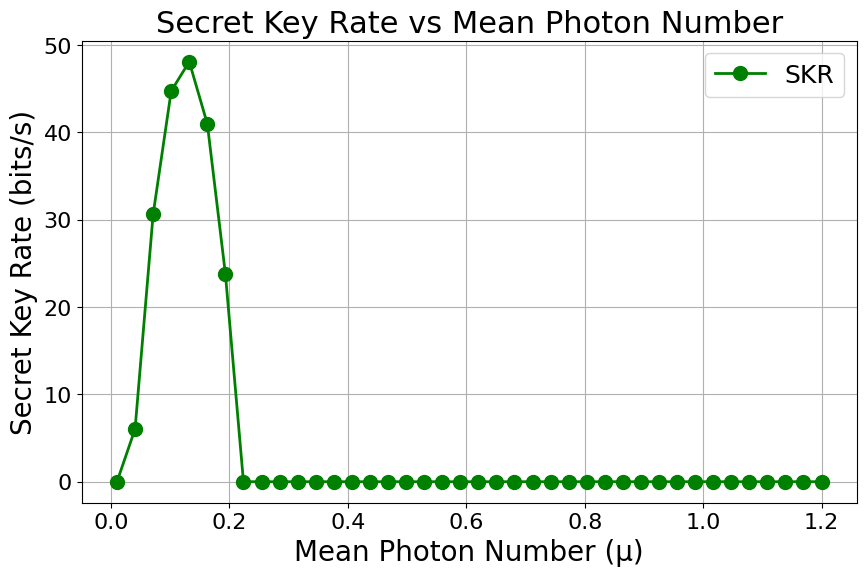

Optimal μ value for maximum SKR: 0.132
Maximum Secret Key Rate: 48.1 bits/second


In [12]:
# Plot Secret Key Rate vs mean photon number
mu_values, skr_values = plot_skr_vs_mu(
    time_window=time_window,
    distance=distance,
    detector_efficiency=detector_eff,
    channel_base_efficiency=channel_eff,
    dark_count_rate=dark_counts,
    repetition_rate=1e6  # 1 MHz pulse rate
)

# Show the optimal mu value (maximum SKR)
max_skr_idx = np.argmax(skr_values)
print(f"Optimal μ value for maximum SKR: {mu_values[max_skr_idx]:.3f}")
print(f"Maximum Secret Key Rate: {skr_values[max_skr_idx]:.1f} bits/second")

Analysis:

- The optimal μ for maximizing SKR is typically lower than the optimal μ for minimizing QBER
- This is because privacy amplification penalties for multi-photon pulses reduce the SKR
- At high μ values, the security of the protocol diminishes due to multi-photon vulnerabilities
- At low μ values, the raw detection rate is too low to generate significant key material


## 4.3 QBER vs Distance
Let's examine how the distance between Alice and Bob affects the QBER. This is crucial for understanding the range limitations of QKD systems.

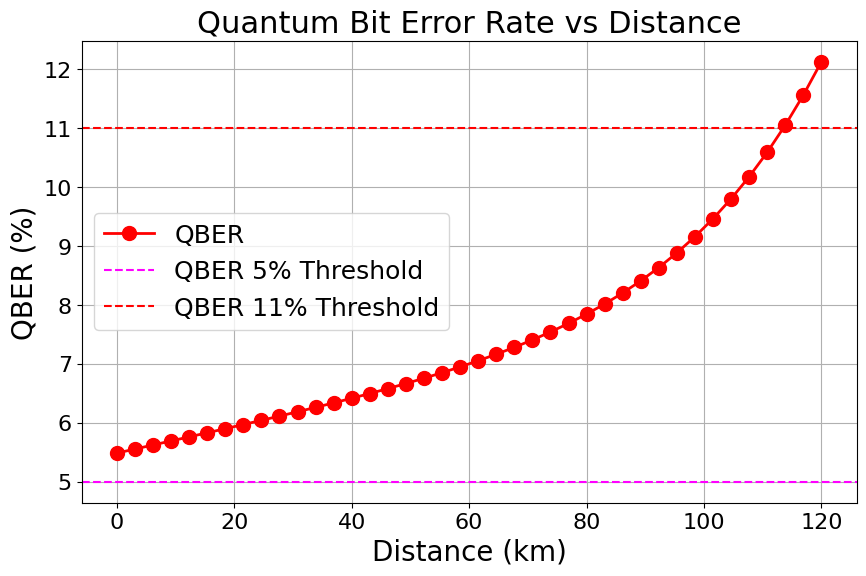

Maximum secure distance (QBER < 11%): 110.8 km


In [13]:
# Use a moderate mean photon number
mu = 0.5

# Plot QBER vs distance
distance_values, qber_values = plot_qber_vs_distance(
    mu=mu,
    time_window=time_window,
    detector_efficiency=detector_eff,
    channel_base_efficiency=channel_eff,
    dark_count_rate=dark_counts
)

# Find maximum secure distance (QBER < 11%)
secure_distances = [d for d, q in zip(distance_values, qber_values) if q < 11]
max_secure_distance = max(secure_distances) if secure_distances else 0
print(f"Maximum secure distance (QBER < 11%): {max_secure_distance:.1f} km")

Analysis:

- The QBER increases with distance due to:
1. Decreasing signal-to-noise ratio as optical losses increase
2. Increasing contribution of dark counts relative to signal
3. Increasing optical misalignment errors
- Beyond the maximum secure distance, no secret key can be generated

## 4.4 Secret Key Rate vs Distance
Now let's examine how the distance affects the secret key rate (SKR). This shows the practical range and performance of the QKD system.

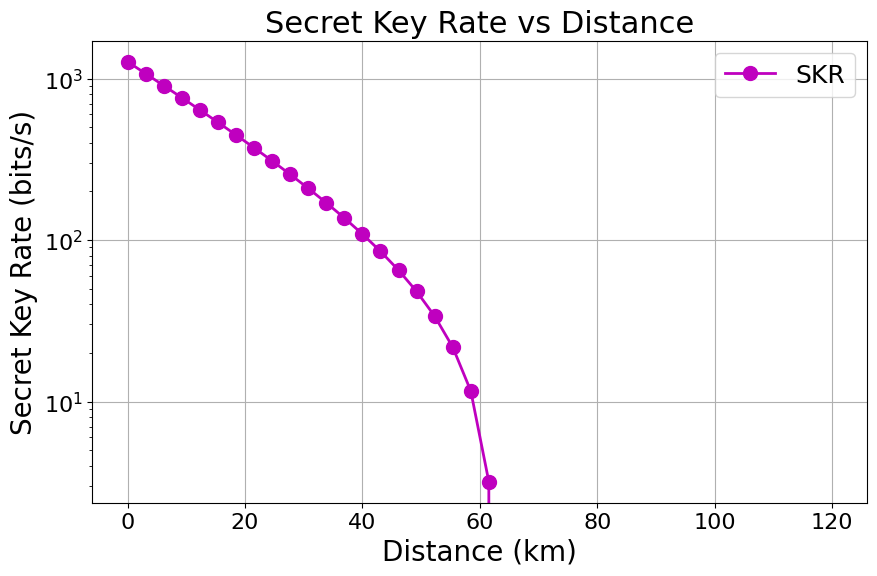

Maximum distance with positive SKR: 61.5 km


In [14]:
# Use a lower mean photon number for better distance performance
mu = 0.1

# Plot Secret Key Rate vs distance
distance_values, skr_values = plot_skr_vs_distance(
    mu=mu,
    time_window=time_window,
    detector_efficiency=detector_eff,
    channel_base_efficiency=channel_eff,
    dark_count_rate=dark_counts,
    repetition_rate=1e6  # 1 MHz pulse rate
)

# Find maximum distance with non-zero SKR
positive_skr_distances = [d for d, s in zip(distance_values, skr_values) if s > 0]
max_positive_skr_distance = max(positive_skr_distances) if positive_skr_distances else 0
print(f"Maximum distance with positive SKR: {max_positive_skr_distance:.1f} km")

Analysis:

- The SKR decreases exponentially with distance due to:
1. Exponential decrease in channel transmission (0.2 dB/km fiber loss)
2. Increasing QBER, which increases error correction and privacy amplification costs
- The semi-log plot shows that SKR follows approximately a straight line on logarithmic scale
- The maximum distance is limited by the point where QBER becomes too high or SKR becomes zero

## 4.5 Effects of Eavesdropping
Finally, let's examine how an eavesdropper (Eve) affects the QKD system performance. We model a simple intercept-resend attack where Eve intercepts and measures a fraction of the photons.



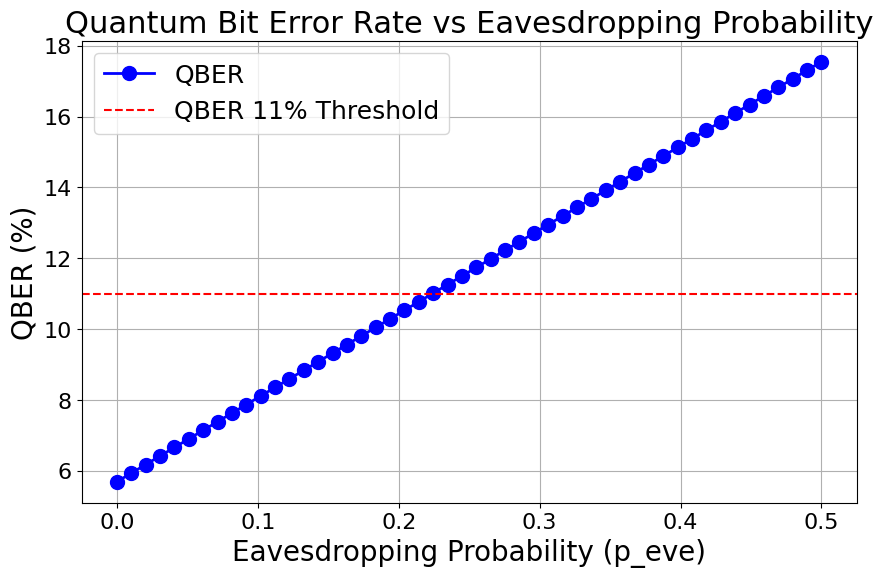

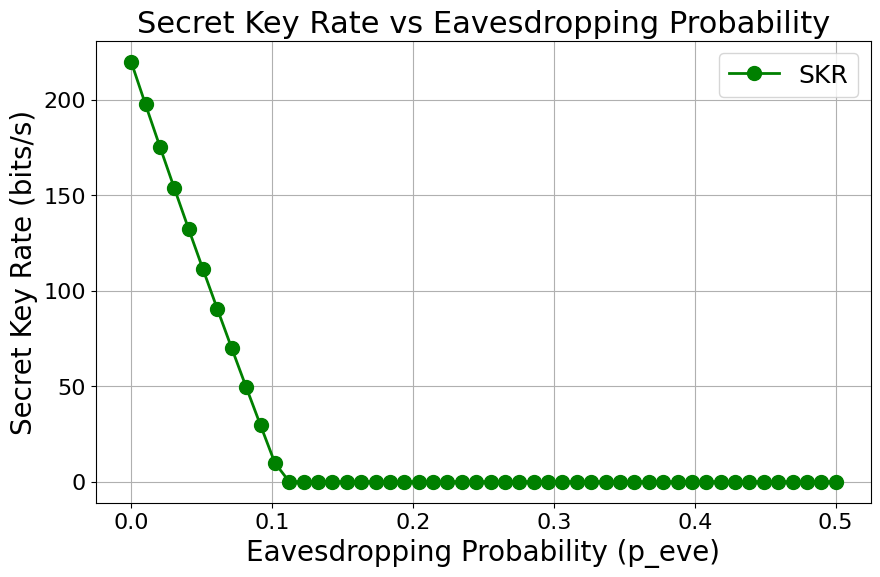

Eavesdropping detection threshold (QBER > 5%): 0.000


In [15]:
# Use a lower mean photon number for better security
mu = 0.1
distance = 30  # Shorter distance to better see eavesdropping effects

# Plot QBER and SKR vs eavesdropping probability
p_eve_values, qber_values, skr_values = plot_qber_skr_vs_eavesdropping(
    mu=mu,
    time_window=time_window,
    distance=distance,
    detector_efficiency=detector_eff,
    channel_base_efficiency=channel_eff,
    dark_count_rate=dark_counts,
    repetition_rate=1e6  # 1 MHz pulse rate
)

# Find eavesdropping detection threshold
detection_threshold = next((i for i, q in enumerate(qber_values) if q > 5), len(qber_values))
if detection_threshold < len(p_eve_values):
    print(f"Eavesdropping detection threshold (QBER > 5%): {p_eve_values[detection_threshold]:.3f}")
else:
    print("Eavesdropping not detectable with these parameters")

Analysis:

- As eavesdropping probability increases, QBER increases due to disturbances caused by Eve's measurements
- This demonstrates the security principle of QKD: any eavesdropping attempt can be detected

## 5. Conclusion

This notebook has demonstrated a comprehensive simulation of the BB84 quantum key distribution protocol with weak coherent sources. We've explored key performance metrics and their relationships with important system parameters:

### Mean Photon Number (μ)
- Controls the trade-off between key rate and security
- Optimal values typically range from 0.1 to 0.5
- Lower values provide better security against PNS attacks
- Higher values provide better raw key rates but require more privacy amplification

### Distance
- Exponentially decreases channel efficiency (0.2 dB/km)
- Increases dark count contribution relative to signal
- Practical limit for fiber-based BB84 is typically 100-150 km without quantum repeaters
- QBER increases with distance until it exceeds security threshold

### Eavesdropping
- Introduces detectable errors in the key
- Security is guaranteed by quantum principles: measurement disturbs the system
- When eavesdropping exceeds detection threshold, users abort the protocol

# Key Security Concepts

#### Photon Number Splitting (PNS) Attacks
- Multi-photon pulses are vulnerable to PNS attacks
- Privacy amplification must account for this information leakage
- Decoy state protocols (not simulated here) can mitigate PNS attacks

#### QBER Thresholds
- Warning threshold (~5%): Indicates possible eavesdropping
- Security threshold (~11%): Beyond this, no secure key can be generated

#### Post-Processing
- Error correction: Reconciles Alice and Bob's keys (costly for high QBER)
- Privacy amplification: Reduces Eve's potential knowledge of the key

# Further Improvements
- Decoy State Protocol: Adding decoy states would improve security against PNS attacks
- Finite-Size Effects: Including statistical fluctuations for finite key lengths
- MDI-QKD: Measurement-device-independent QKD to eliminate detector vulnerabilities
- Entanglement-Based QKD: Using entangled photon pairs instead of weak coherent states